In [824]:
import numpy as np
import matplotlib.pyplot as plt

In [825]:
# grid and stuff
Lx = Lz = 2000

Nx = Nz = 101

dx = Lx / (Nx - 1)
dz = Lz / (Nz - 1)

x = np.linspace(0, Lx, Nx)
z = np.linspace(0, Lz, Nz)
X, Z = np.meshgrid(x, z, indexing='ij')

# constants
temp0 = 300
dtemp = 1
g = 9.81
x0 = Lx/2
z0 = 260

dt = 0.05

A = 100
wavelength = Lx

v_art = g_art = 0#2*r0*U/Re maybe try 0.1-0.2

T_tot = 500
Nt = int(T_tot/dt)

In [826]:
atwood = 0.04


In [827]:
t0 = 0
t2 = 1/np.sqrt(atwood*g/wavelength)
t4 = 3/np.sqrt(atwood*g/wavelength)
t6 = 5/np.sqrt(atwood*g/wavelength)
t8 = 7/np.sqrt(atwood*g/wavelength)

print(t2, t4 ,t6,t8)

71.39215614635322 214.17646843905965 356.9607807317661 499.74509302447257


In [828]:
courant_numbers = []
neumann_temp_list = []
neumann_vort_list = []
sor_iterations = []

In [829]:
def init_temp(X, Z):
    interface = Lz / 2
    perturb = -A * np.sin(2 * np.pi* X / wavelength)
    theta = np.where(Z + perturb < interface, temp0 + dtemp, temp0 - dtemp)
    return theta

temp = np.zeros((Nx + 2, Nz + 2))
vort = np.zeros_like(temp)
psi = np.zeros_like(temp)

temp_old = np.zeros_like(temp)
vort_old = np.zeros_like(vort)

temp[1:Nx+1, 1:Nz+1] = init_temp(X,Z)

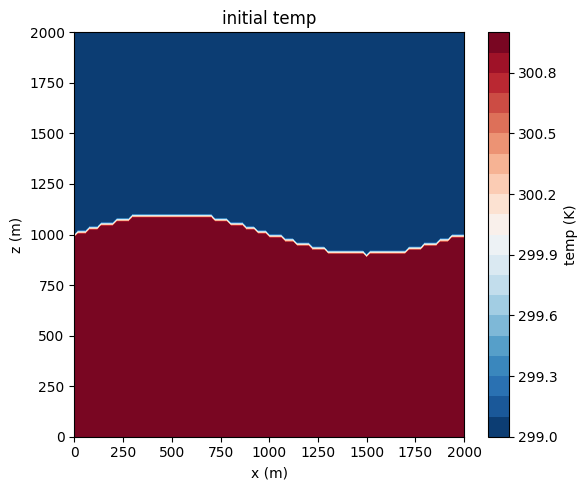

In [830]:
plt.figure(figsize=(6, 5))
plt.contourf(X, Z, temp[1:-1, 1:-1], 20, cmap='RdBu_r')
plt.colorbar(label='temp (K)')
plt.title('initial temp')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.tight_layout()
plt.show()

In [831]:
def arakawa_jacobian(a, b, dx, dz):
    J = np.zeros((Nx + 2, Nz +2))

    for i in range(1, Nx + 1):
        for j in range(1, Nz + 1):

            J1 = (
                ((a[i+1, j] - a[i-1, j])*(b[i,j+1] - b[i,j-1]) - 
                (a[i, j+1] - a[i, j-1])*(b[i+1,j] - b[i-1, j])) / (4*dx*dz)
            )

            J2 = (
                ((a[i+1,j]*(b[i+1,j+1]-b[i+1,j-1]) - a[i-1,j]*(b[i-1,j+1]-b[i-1,j-1])) - 
                 (a[i,j+1]*(b[i+1,j+1]-b[i-1,j+1]) - a[i,j-1]*(b[i+1,j-1]-b[i-1,j-1]))) / (4*dx*dz)


            )

            J3 = (
                ((b[i,j+1]*(a[i+1,j+1]-a[i-1,j+1]) - b[i,j-1]*(a[i+1,j-1]-a[i-1,j-1])) -
                (b[i+1,j]*(a[i+1,j+1]-a[i+1,j-1]) - b[i-1,j]*(a[i-1,j+1]-a[i-1,j-1]))) / (4*dx*dz)
            )

            J[i, j] = (J1 + J2 + J3) / 3

    return J

In [832]:
from numba import njit

@njit
def poisson_sor(rhs, dx, dz, Nx, Nz):
    tol = 1e-8 ##reduce this
    max_iter = 500
    alpha = 1.9

    psi = np.zeros_like(rhs)
    inv_dx2 = 1.0 / dx**2
    inv_dz2 = 1.0 / dz**2
    denom = 2.0 * (inv_dx2 + inv_dz2)

    eps = 1e10
    iteration = 0

    while eps > tol and iteration < max_iter:
        psi[0, 1:-1] = psi[Nx, 1:-1]
        psi[Nx + 1, 1:-1] = psi[1, 1:-1]
        psi[:, 0] = psi[:, Nz + 1] = 0

        max_residual = 0
        sum_psi = 0

        for i in range(1, Nx + 1):
            for j in range(1, Nz + 1):
                rij = (
                    inv_dx2 * (psi[i + 1, j] + psi[i - 1, j]) +
                    inv_dz2 * (psi[i, j + 1] + psi[i, j - 1]) -
                    denom * psi[i, j] - rhs[i, j]
                )
                psi[i, j] += alpha * rij / denom

                if abs(rij) > max_residual:
                    max_residual = abs(rij)
                sum_psi += abs(psi[i, j])

        eps = max_residual / (denom * sum_psi + 1e-12)
        iteration += 1

    return psi, iteration

In [833]:
for field in [psi, temp, vort]:
    field[0, 1:-1]   = field[-2, 1:-1] 
    field[-1, 1:-1]  = field[1, 1:-1]

# dirichlet z
psi[:, 0] = psi[:, -1] = 0
vort[:, 0] = vort[:, -1] = 0
temp[:, 0] = temp[:, -1] = temp0     

#solve sor
rhs = -vort
psi,sor_iter = poisson_sor(rhs, dx, dz,Nz,Nz)
sor_iterations.append(sor_iter)

neumann_temp = g_art * dt / dx**2
neumann_vort = v_art * dt / dx**2
neumann_temp_list.append(neumann_temp)
neumann_vort_list.append(neumann_vort)


#jacobians
J_vort = arakawa_jacobian(psi, vort, dx, dz)
J_temp = arakawa_jacobian(psi, temp, dx, dz)

#laplacian
lap_vort = ((vort[2:,1:-1] - 2*vort[1:-1,1:-1] + vort[0:-2,1:-1]) / (dx**2) -
            (vort[1:-1,2:] - 2*vort[1:-1,1:-1] + vort[1:-1, 0:-2]) / (dz**2))

lap_temp = ((temp[2:,1:-1] - 2*temp[1:-1,1:-1] + temp[0:-2,1:-1]) / (dx**2) -
            (temp[1:-1,2:] - 2*temp[1:-1,1:-1] + temp[1:-1, 0:-2]) / (dz**2))

buoy = (-g / temp0) * (temp[2:, 1:-1] - temp[0:-2, 1:-1]) / (2 * dx)

#vort
vort[1:-1,1:-1] += dt * (-J_vort[1:-1, 1:-1] - buoy + v_art*lap_vort)

#temp
temp[1:-1,1:-1] += dt * (-J_temp[1:-1,1:-1] - g_art*lap_temp)


temp_old[1:-1, 1:-1] = temp[1:-1, 1:-1]
vort_old[1:-1, 1:-1] = vort[1:-1, 1:-1]


In [834]:
frames = []
frame_int = 20

snapshot_times = [t0, t2, t4, t6, t8]
snapshot_steps = [int(t / dt) for t in snapshot_times]
snapshots = {}

froude_numbers = []

lapmax = []
lapmin = []


for n in range(1, Nt):
    t = n * dt

    # periodic x
    for field in [psi, temp, vort]:
        field[0, 1:-1]   = field[-2, 1:-1] 
        field[-1, 1:-1]  = field[1, 1:-1]

    # dirichlet z
    psi[:, 0] = psi[:, -1] = 0
    vort[:, 0] = vort[:, -1] = 0
    temp[:, 0] = temp[:, -1] = temp0     

    #solve sor
    rhs = -vort
    psi, sor_iter = poisson_sor(rhs, dx, dz,Nz,Nz)

    #jacobians
    J_vort = arakawa_jacobian(psi, vort, dx, dz)    
    J_temp = arakawa_jacobian(psi, temp, dx, dz)

    #laplacian
    lap_vort = ((vort[2:,1:-1] - 2*vort[1:-1,1:-1] + vort[0:-2,1:-1]) / (dx**2) -
                (vort[1:-1,2:] - 2*vort[1:-1,1:-1] + vort[1:-1, 0:-2]) / (dz**2))

    lap_temp = ((temp[2:,1:-1] - 2*temp[1:-1,1:-1] + temp[0:-2,1:-1]) / (dx**2) -
                (temp[1:-1,2:] - 2*temp[1:-1,1:-1] + temp[1:-1, 0:-2]) / (dz**2))

    lapmax.append(lap_temp.max())
    lapmin.append(lap_temp.min())

    buoy = (-g / temp0) * (temp[2:, 1:-1] - temp[0:-2, 1:-1]) / (2 * dx)


    #temp
    temp_new = temp_old[1:-1, 1:-1] - 2 * dt * J_temp[1:-1, 1:-1] + 2 * dt * g_art * lap_temp

    #vort
    vort_new = (
        vort_old[1:-1, 1:-1] - 2 * dt * J_vort[1:-1, 1:-1] +
        2 * dt * buoy + 2 * dt * v_art * lap_vort
    )

    temp_old[1:-1, 1:-1] = np.copy(temp[1:-1, 1:-1])
    vort_old[1:-1, 1:-1] = np.copy(vort[1:-1, 1:-1])
    temp[1:-1, 1:-1] = np.copy(temp_new)
    vort[1:-1, 1:-1] = np.copy(vort_new)

    if n % 20 == 0:
        sor_iterations.append(sor_iter)

        neumann_temp = g_art * dt / dx**2
        neumann_vort = v_art * dt / dx**2
        neumann_temp_list.append(neumann_temp)
        neumann_vort_list.append(neumann_vort)

        max_buoy = np.max(buoy)
        min_buoy = np.min(buoy)

        u = - (psi[:, 2:] - psi[:, :-2]) / (2 * dz)  # horizontal
        w =   (psi[2:, :] - psi[:-2, :]) / (2 * dx)  # vertical
        u_B = np.max(np.abs(w))

        froude = u_B / np.sqrt((atwood * g * wavelength)/(1+atwood))
        froude_numbers.append(froude)

        print(f"Step {n:4d}, t = {t:7.2f}s | "
            f"max temp = {np.max(temp[1:-1, 1:-1]):.2f}, min temp = {np.min(temp[1:-1, 1:-1]):.2f} | "
            f"max vort = {np.max(vort[1:-1, 1:-1]):.2e} | "
            f"buoy = [{min_buoy:.2e}, {max_buoy:.2e}]")
        
    if n % frame_int == 0:
        frames.append(temp[1:-1, 1:-1].copy())

    if n in snapshot_steps:
        snapshots[n] = temp[1:-1, 1:-1].copy()



Step   20, t =    1.00s | max temp = 301.00, min temp = 299.00 | max vort = 1.55e-03 | buoy = [-1.64e-03, 1.64e-03]
Step   40, t =    2.00s | max temp = 301.00, min temp = 299.00 | max vort = 3.19e-03 | buoy = [-1.64e-03, 1.64e-03]
Step   60, t =    3.00s | max temp = 301.00, min temp = 299.00 | max vort = 4.83e-03 | buoy = [-1.64e-03, 1.64e-03]
Step   80, t =    4.00s | max temp = 301.01, min temp = 298.99 | max vort = 6.46e-03 | buoy = [-1.64e-03, 1.64e-03]
Step  100, t =    5.00s | max temp = 301.01, min temp = 298.99 | max vort = 8.10e-03 | buoy = [-1.64e-03, 1.64e-03]
Step  120, t =    6.00s | max temp = 301.01, min temp = 298.99 | max vort = 9.75e-03 | buoy = [-1.64e-03, 1.64e-03]
Step  140, t =    7.00s | max temp = 301.02, min temp = 298.98 | max vort = 1.14e-02 | buoy = [-1.65e-03, 1.65e-03]
Step  160, t =    8.00s | max temp = 301.02, min temp = 298.97 | max vort = 1.30e-02 | buoy = [-1.65e-03, 1.65e-03]
Step  180, t =    9.00s | max temp = 301.03, min temp = 298.97 | max vor

In [835]:
print(snapshot_times)

[0, np.float64(71.39215614635322), np.float64(214.17646843905965), np.float64(356.9607807317661), np.float64(499.74509302447257)]


C:\Users\obiha\AppData\Local\Temp\ipykernel_17220\1051056843.py:13: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  return c.collections


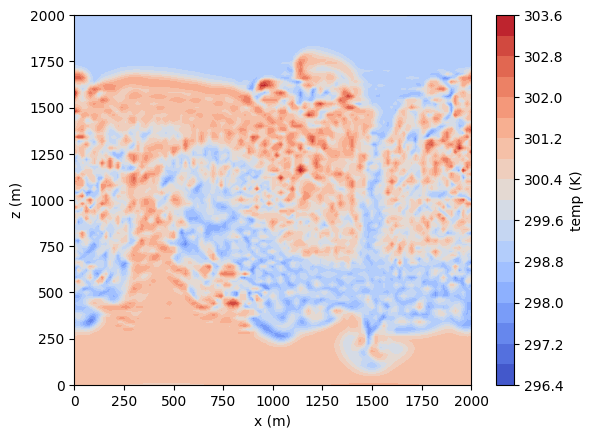

In [836]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
c = ax.contourf(X, Z, frames[-1], levels=20, cmap='coolwarm')
cb = fig.colorbar(c, ax=ax, label='temp (K)')

def update(frame):
    ax.clear()
    c = ax.contourf(X, Z, frame, levels=20, cmap='coolwarm')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
    return c.collections

ani = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=False)
ani.save('4_diff1.gif', writer='pillow', fps=32)
plt.show()

In [837]:
lapmax1 = [v for v in lapmax if not np.isnan(v)]
lapmin1 = [v for v in lapmin if not np.isnan(v)]


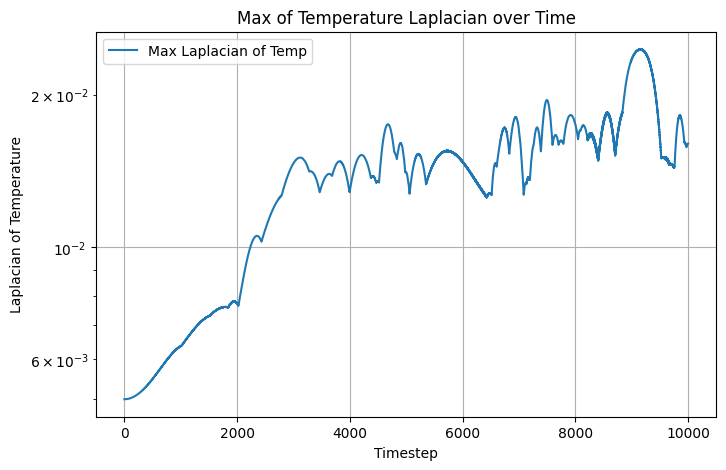

In [838]:
# Remove final value
lapmax1.pop()
lapmin1.pop()

# Then plot
timesteps = range(len(lapmax1))

plt.figure(figsize=(8, 5))
plt.plot(timesteps, lapmax1, label='Max Laplacian of Temp')
plt.xlabel('Timestep')
plt.ylabel('Laplacian of Temperature')
plt.title('Max of Temperature Laplacian over Time')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()


In [839]:
print(range(len(froude_numbers)))

range(0, 499)


C:\Users\obiha\AppData\Local\Temp\ipykernel_17220\3663570520.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


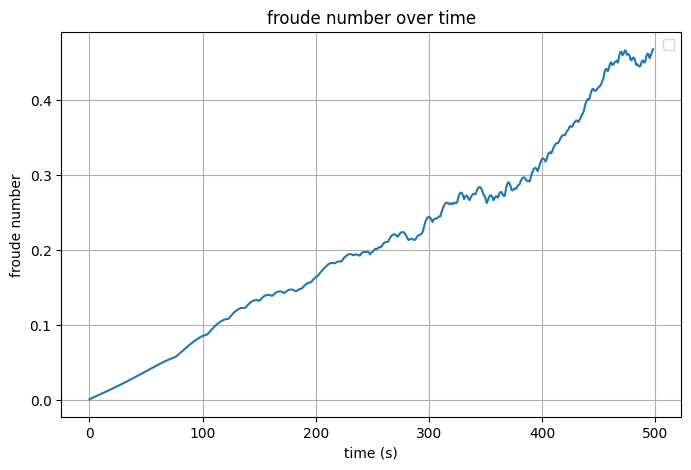

In [840]:
timesteps = range(len(froude_numbers))

plt.figure(figsize=(8, 5))
plt.plot(timesteps, froude_numbers)
plt.xlabel('time (s)')
plt.ylabel('froude number')
plt.title('froude number over time')
plt.legend()
plt.grid(True)
plt.show()

In [841]:
n_snapshots = len(snapshots)
print(f"Number of snapshots: {n_snapshots}")

Number of snapshots: 4


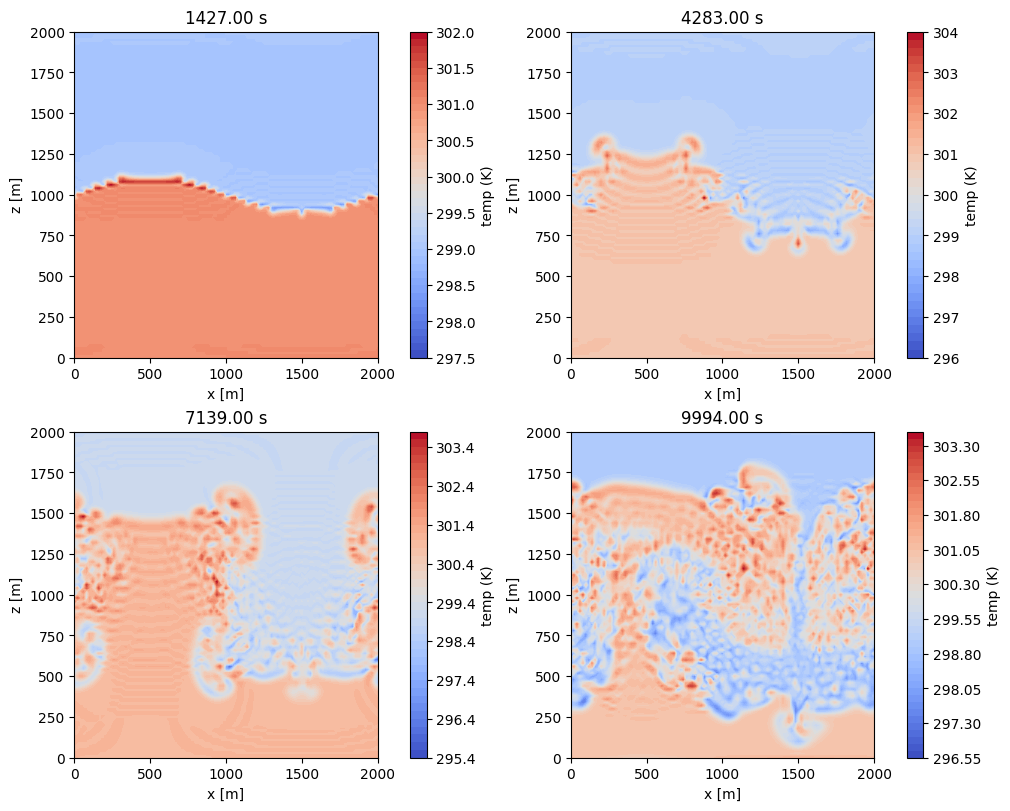

In [842]:
n_snapshots = len(snapshots)
cols = 2  # number of plots per row
rows = int(np.ceil(n_snapshots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), constrained_layout=True)

# Flatten axes array for easy indexing
axes = axes.flatten() if n_snapshots > 1 else [axes]

for ax, (t, field) in zip(axes, snapshots.items()):
    cf = ax.contourf(X, Z, field, levels=50, cmap='coolwarm')
    fig.colorbar(cf, ax=ax, orientation='vertical', label='temp (K)')
    ax.set_title(f"{t:7.2f} s")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("z [m]")

# Hide any unused subplots
for i in range(len(snapshots), len(axes)):
    fig.delaxes(axes[i])

plt.show()